### Fitting a one term Ogden model tutorial

##### Description
The goal of this notebook is to demonstrate how to fit the parameters of a constitutive model using a least squares optimization approach. This notebook contains code to:
* Import a text file of experimental Force vs. displacement data for a simple shear experiment
* Fit a one term Ogden model to the data based on an analytical approximation of the simple shear experiment
* Fit a one term Ogden model to the data based on a 3D FEA simulation of the simple shear experiment. The FEA simulations are performed with a FEBio executable, see additional info below. 
* Visualize the results

##### Python packages required
The following Python packages are required to run the code: 
* matplotlib
* numpy
* os
* scipy -- in particular, "interpolate.interp1d" and "optimization.curve_fit" functions are used

##### Additional files required
The following must be in the same directory as this notebook for it to run as written:
* "example_data.txt" -- experimental data file
* febio3 executable (see FEBio setup section)
* "FEA/ThrombusMaterial.feb" file for updating FEA material properties
* "FEA/ThrombusPureShear.feb" file for running the FEA simulations

##### FEBio setup
FEBio is free to download https://febio.org/febio/febio-downloads/ -- in our code, the command "os.system('febio3 -i FEA/ThrombusPureShear.feb >/dev/null 2>&1')" is used to run the executable "febio3" (must be downloaded from the link) on the file "ThrombusPureShear.feb" with command ">/dev/null 2>&1" used to supress the FEBio output. This command is written for the scenario where a copy of the "febio3" executable is in the same folder as the script. If this is not the case, the command must be adjusted accordingly. Prior to each run of "ThrombusPureShear.feb" we update the file "ThrombusMaterial.feb" to reflect the next iteration of material parameters. The file "ThrombusPureShear.feb" draws material parameters from "ThrombusMaterial.feb" and both files are stored in the "FEA" folder. Each run of the "ThrombusPureShear.feb" simulation outputs file "FEA/RigidForce.txt" where the third column contains the total force applied to deform the sample in pure shear. 

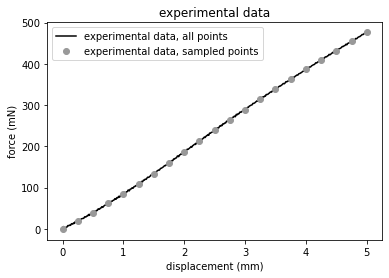

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

# import the experimental data
# in this text file, the first column is displacement in mm, the second column is force in mN
data = np.loadtxt('example_data.txt') 

# down sample the experimental data (to match future FEA output) 
# we will also enforce (0 mm, 0 mN) as the first datapoint -- this isn't necessary 
x_data = np.linspace(0.25,5,20)
f = interpolate.interp1d(data[:,0],data[:,1],fill_value="extrapolate")
y_data = f(x_data)
expt_disp = np.zeros(x_data.shape[0] + 1); expt_force = np.zeros(y_data.shape[0] + 1)
expt_disp[1:] = x_data; expt_force[1:] = y_data

# plot the experimental data
plt.plot(data[:,0],data[:,1],'k-',label='experimental data, all points')
plt.plot(expt_disp,expt_force,'o',markerfacecolor=(153/255,153/255,153/255),markeredgecolor=(153/255,153/255,153/255),label='experimental data, sampled points')
plt.legend()
plt.xlabel('displacement (mm)'); plt.ylabel('force (mN)')
plt.title('experimental data')
plt.savefig('experimental_data_force_vs_disp')

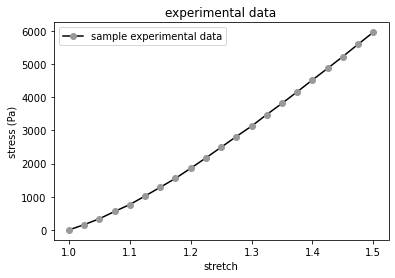

In [2]:
# convert experimental force vs. displacement data into stress vs. strain data
# sample dimensions: 
dim_1 = 40.0 #mm
dim_2 = 10.0 #mm
dim_3 = 3.0  #mm

cross_section_area = dim_1 * dim_3 # mm^2
lambda_stretch_expt = 1 + expt_disp / dim_2 # dimensionless

# note: we convert force to N, and length to m, so the resulting stress is in N / m^2 = Pa 
sigma_expt = expt_force * 0.001 / (cross_section_area * 0.001**2.0) * lambda_stretch_expt 

# visualize results 
plt.figure()
plt.plot(lambda_stretch_expt, sigma_expt, 'ko-',markerfacecolor=(153/255,153/255,153/255),markeredgecolor=(153/255,153/255,153/255), label='sample experimental data')
plt.legend(); plt.xlabel('stretch'); plt.ylabel('stress (Pa)')
plt.title('experimental data')
plt.savefig('experimental_data_stress_vs_stretch')

In [3]:
import scipy.optimize as optimization
# here we will fit the analytical model to the experimental data using optimization.curve_fit

# define two lists to keep track of how the parameters change during the fitting process 
alpha_iterate = []; mu_0_iterate = [] 

def ogden_fcn(stretch_ogden, alpha, mu_0):
    """Analytical stress vs. stretch function, one term Ogden model"""
    sigma_ogden = 2.0 * mu_0 * ( stretch_ogden ** alpha - stretch_ogden ** (-1.0 * alpha) ) / alpha
    alpha_iterate.append(alpha); mu_0_iterate.append(mu_0) # just keeping track of the parameters here
    return sigma_ogden

# initial guess for parameters
alpha = 1; mu_0 = 1000; x0 = np.array([alpha, mu_0])

# perform optimization
output = optimization.curve_fit(ogden_fcn, lambda_stretch_expt, sigma_expt, x0, bounds= ([-100,0],[100,np.inf]))

# extract optimization results 
parameters = output[0]; alpha_fitted = parameters[0]; mu_0_fitted = parameters[1] 

# get stress fitted with the Ogden model 
sigma_ogden_fitted = ogden_fcn(lambda_stretch_expt, alpha_fitted, mu_0_fitted)

# convert the fitted stress into force
analytical_force = sigma_ogden_fitted / .001 * (cross_section_area * 0.001**2.0) / lambda_stretch_expt

# compute the error in comparison to the experimental data
RMSE_analytical = np.sqrt( np.sum( (expt_force - analytical_force)**2.0 )  / len(expt_force) )

print('optimization complete!')
print('alpha:', alpha_fitted, 'unitless')
print('mu_0:',mu_0_fitted, 'Pa')
print('RMSE based on force vs. disp:',RMSE_analytical)

optimization complete!
alpha: 4.28006865451736 unitless
mu_0: 2378.167793349671 Pa
RMSE based on force vs. disp: 9.915054611609078


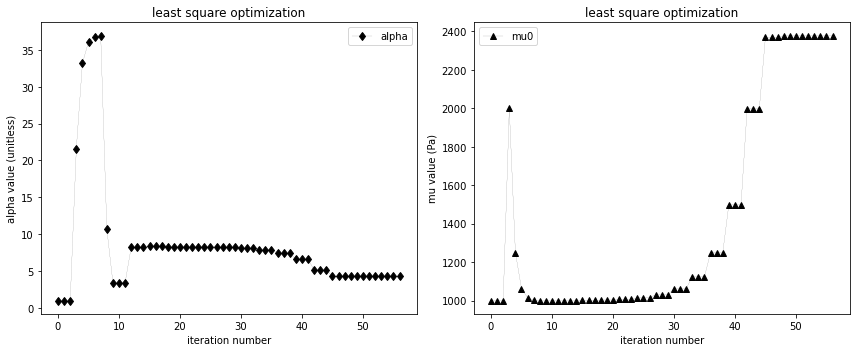

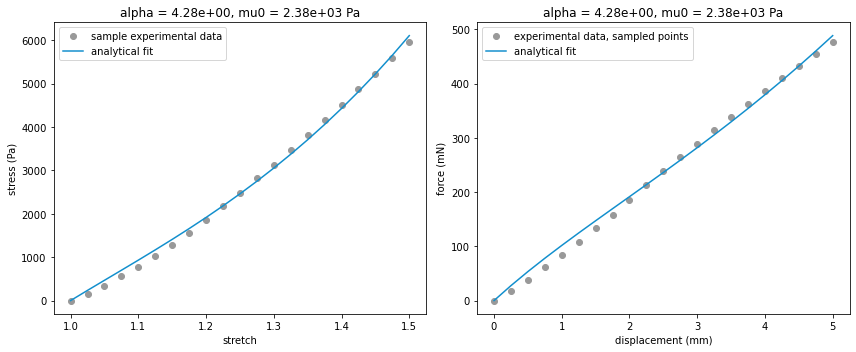

In [4]:
# visualize the analytical model fit

# first we will plot the fitting parameters with respect to iteration number to visualize the optimization process
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(alpha_iterate[:-1],'kd-',linewidth=.1,label='alpha')
plt.legend(); plt.xlabel('iteration number'); plt.ylabel('alpha value (unitless)'); plt.title('least square optimization')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(mu_0_iterate[:-1],'k^-',linewidth=.1,label='mu0')
plt.legend(); plt.xlabel('iteration number'); plt.ylabel('mu value (Pa)'); plt.title('least square optimization')
plt.tight_layout()
plt.savefig('analytical_optimization_process')

# then we will plot the fitting results 
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(lambda_stretch_expt, sigma_expt,'o',markerfacecolor=(153/255,153/255,153/255),markeredgecolor=(153/255,153/255,153/255),label='sample experimental data')
plt.plot(lambda_stretch_expt, sigma_ogden_fitted, '-',color=(18/255, 143/255, 205/255),label='analytical fit')
plt.legend(); plt.xlabel('stretch'); plt.ylabel('stress (Pa)')
plt.title('alpha = %.2e, mu0 = %.2e Pa'%(alpha_fitted, mu_0_fitted))
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(expt_disp,expt_force,'o',markerfacecolor=(153/255,153/255,153/255),markeredgecolor=(153/255,153/255,153/255),label='experimental data, sampled points')
plt.plot(expt_disp,analytical_force, '-',color=(18/255, 143/255, 205/255),label='analytical fit')
plt.legend(); plt.xlabel('displacement (mm)'); plt.ylabel('force (mN)')
plt.title('alpha = %.2e, mu0 = %.2e Pa'%(alpha_fitted, mu_0_fitted))
plt.tight_layout()
plt.savefig('analytical_fit_result')

In [15]:
import scipy.optimize as optimization
import os 
# fit the FEA model and visualize the results 
#   -- note this will require calling an FEBio executable that has to be downloaded separately
#   -- please see the initial markdown cell for info on where you can download FEBio 

def update_material_file(alpha_value, mu_value):
    """function to update the file ThrombusMaterial.feb file with new iteration of material parameters"""
    lines = []
    with open('FEA/ThrombusMaterial.feb') as f:
        lines = f.readlines()
    # line 10 covers C1 
    lines[10] = '\t\t\t<c1>%.12e</c1>\n'%(mu_value)
    # line 16 covers m1 
    lines[16] = '\t\t\t<m1>%.12e</m1>\n'%(alpha_value)
    f.close()
    # re-write feb file 
    with open('FEA/ThrombusMaterial.feb', 'w') as f:
        for line in lines:
            f.write(line)
    f.close()
    return 

alpha_iterate_FEA = []; mu_0_iterate_FEA = []; # these will keep track of the parameters during optimization iterations
def ogden_fcn_FEA(displacement, alpha, mu_0):
    """function to call FEBio"""
    # update material properties -- calls the above function
    update_material_file(alpha,mu_0)
    alpha_iterate_FEA.append(alpha); mu_0_iterate_FEA.append(mu_0)
    # call FE Bio from python 
    os.system('febio3 -i FEA/ThrombusPureShear.feb >/dev/null 2>&1')
    #os.system('febio3 -i FEA/Thrombus1200Elements.feb >/dev/null 2>&1') # this is a coarse FEA mesh used for debugging
    # read in RigidForce.txt column 0 is nothing, column 1 is displacement, column 2 is force
    FE_results_import = np.loadtxt('FEA/RigidForce.txt')
    # append 0 to the first entry of the force data
    FE_results = np.zeros((FE_results_import.shape[0] + 1)); FE_results[1:] = FE_results_import[:,2]
    rigid_force = FE_results * 4.0  # multiply by 4 b/c only 1/8 of the domain is simulated
    return rigid_force

# initial guess for parameters
alpha = 1; mu_0 = 1000; x0 = np.array([alpha, mu_0])

# perform optimization
expt_force_fit_units = expt_force * 10 ** 3.0 # convert experimental data into micro-Newtons so that mu_0 will be in Pa
output = optimization.curve_fit(ogden_fcn_FEA, expt_disp, expt_force_fit_units , x0, bounds= ([-100,0],[100,np.inf])) 

# extract optimization results 
parameters = output[0]; alpha_fitted_FEA = parameters[0]; mu_0_fitted_FEA = parameters[1] 
mu_0_fitted_FEA_convert = mu_0_fitted_FEA / 2.0 # changing the FEBio formulation to match the analytical

# get force from the FEA model (saved as a text file)
FE_results_import = np.loadtxt('FEA/RigidForce.txt'); FE_results = np.zeros((FE_results_import.shape[0] + 1)); FE_results[1:] = FE_results_import[:,2]
FEA_force = FE_results * 4.0 * 10.0**-3 # convert back to mN, multiply by 4 b/c only 1/8 of the domain is simulated

# compute the error in comparison to the experimental data
RMSE_FEA = np.sqrt( np.sum( (expt_force - FEA_force)**2.0 )  / len(expt_force) )

print('optimization complete!')
print('alpha:', alpha_fitted_FEA, 'unitless')
print('mu_0:',mu_0_fitted_FEA_convert, 'Pa')
print('RMSE based on force vs. disp:',RMSE_FEA)

optimization complete!
alpha: 4.175454824210303 unitless
mu_0: 2248.7988262918157 Pa
RMSE based on force vs. disp: 8.718904322568099


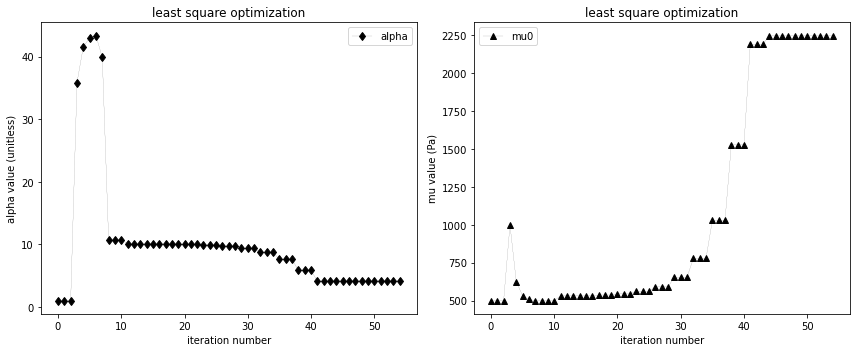

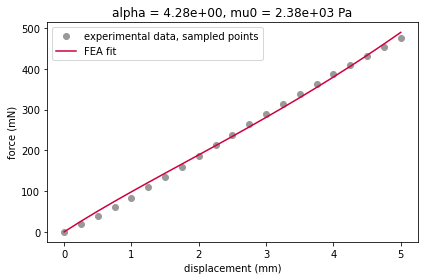

In [16]:
# visualize the FEA model fit

# first we will plot the fitting parameters with respect to iteration number to visualize the optimization process
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(alpha_iterate_FEA[:-1],'kd-',linewidth=.1,label='alpha')
plt.legend(); plt.xlabel('iteration number'); plt.ylabel('alpha value (unitless)'); plt.title('least square optimization')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(0.5*np.asarray(mu_0_iterate_FEA[:-1]),'k^-',linewidth=.1,label='mu0')
plt.legend(); plt.xlabel('iteration number'); plt.ylabel('mu value (Pa)'); plt.title('least square optimization')
plt.tight_layout()
plt.savefig('FEA_optimization_process')

# then we will plot the fitting results 
plt.figure()
plt.plot(expt_disp,expt_force,'o',markerfacecolor=(153/255,153/255,153/255),markeredgecolor=(153/255,153/255,153/255),label='experimental data, sampled points')
plt.plot(expt_disp,FEA_force, '-',color=(205/255, 0/255, 61/255),label='FEA fit')
plt.legend(); plt.xlabel('displacement (mm)'); plt.ylabel('force (mN)')
plt.title('alpha = %.2e, mu0 = %.2e Pa'%(alpha_fitted, mu_0_fitted))
plt.tight_layout()
plt.savefig('FEA_fit_result')

-------------------------------------------------
alpha analytical: 4.28006865451736 unitless
mu_0 analytical : 2378.167793349671 Pa
-------------------------------------------------
alpha FEA: 4.175454824210303 unitless
mu_0 FEA: 2248.7988262918157 Pa
-------------------------------------------------


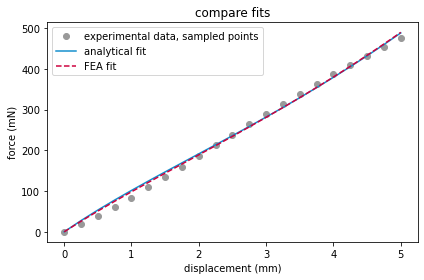

In [17]:
# Finally, we can compare the FEA and experimental fits
plt.figure()
plt.plot(expt_disp,expt_force,'o',markerfacecolor=(153/255,153/255,153/255),markeredgecolor=(153/255,153/255,153/255),label='experimental data, sampled points')
plt.plot(expt_disp,analytical_force, '-',color=(18/255, 143/255, 205/255),label='analytical fit')
plt.plot(expt_disp,FEA_force, '--',color=(205/255, 0/255, 61/255),label='FEA fit')
plt.legend(); plt.xlabel('displacement (mm)'); plt.ylabel('force (mN)')
plt.title('compare fits')
plt.tight_layout()
plt.savefig('compare_analytical_and_FEA_fit_result')

print('-------------------------------------------------')
print('alpha analytical:', alpha_fitted, 'unitless')
print('mu_0 analytical :',mu_0_fitted, 'Pa')
print('-------------------------------------------------')
print('alpha FEA:', alpha_fitted_FEA, 'unitless')
print('mu_0 FEA:',mu_0_fitted_FEA_convert, 'Pa')
print('-------------------------------------------------')